In [88]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Load dataset

In [16]:
%%capture

!pip install datasets transformers

In [98]:
from datasets import load_dataset, Image

dataset_handle = "vojtam/vegetables"
dataset = load_dataset(dataset_handle)

Resolving data files:   0%|          | 0/596 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

In [99]:
dataset = dataset.cast_column("image", Image(mode="RGB"))

In [100]:
dataset.set_format(type='torch')

## Rescale dataset

In [102]:
for img in dataset['train']['image'][:20]:
    print(img.shape)

torch.Size([3, 1650, 1100])
torch.Size([3, 500, 500])
torch.Size([3, 1328, 1160])
torch.Size([3, 1306, 1979])
torch.Size([3, 1159, 1256])
torch.Size([3, 1200, 800])
torch.Size([3, 1536, 1024])
torch.Size([3, 498, 750])
torch.Size([3, 682, 1024])
torch.Size([3, 449, 599])
torch.Size([3, 836, 1254])
torch.Size([3, 1800, 1200])
torch.Size([3, 1800, 1200])
torch.Size([3, 668, 1024])
torch.Size([3, 1366, 2048])
torch.Size([3, 900, 1200])
torch.Size([3, 401, 602])
torch.Size([3, 1024, 1024])
torch.Size([3, 2133, 1600])
torch.Size([3, 1000, 1500])


In [103]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

def transform_dataset(examples):
    examples['image'] = [transform(image) for image in examples['image']]
    return examples


In [104]:
dataset.set_transform(transform_dataset)

In [105]:
train_set = dataset['train']
test_set = dataset['test']

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [126]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=1152, out_features=512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x


model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (drop1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [127]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [137]:
n = 20

for epoch in range(n):  # Train for n epochs
    running_loss = 0.0
    for batch in train_loader:
        # Move images and labels to the device
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{n}], Loss: {running_loss / len(train_loader):.4f}')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/5], Loss: 0.0558
Epoch [2/5], Loss: 0.0642
Epoch [3/5], Loss: 0.0431
Epoch [4/5], Loss: 0.0516
Epoch [5/5], Loss: 0.0458


# Eval

In [138]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for batch in test_loader:
        # Move images and labels to the device
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 70.53%


In [70]:
dataset.set_format(type="pandas")

In [79]:
def label_int2str(row):
    return dataset['train'].features['label'].int2str(row)

df = test_set[:]
df['label_name'] = df['label'].apply(label_int2str)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [81]:
df['predicted'] = predicted.to('cpu')

In [83]:
df['predicted_label'] = df['predicted'].apply(label_int2str)

In [84]:
df

,image,label,label_name,predicted,predicted_label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,broccoli,1,broccolini
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,broccoli,1,broccolini
2,<PIL.WebPImagePlugin.WebPImageFile image mode=...,0,broccoli,2,cauliflower
3,<PIL.Image.Image image mode=RGB size=2165x2205...,0,broccoli,2,cauliflower
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,broccoli,1,broccolini
...,...,...,...,...,...
90,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,romanesco,3,romanesco
91,<PIL.Image.Image image mode=RGB size=1500x1000...,3,romanesco,1,broccolini
92,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,romanesco,3,romanesco
93,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,romanesco,2,cauliflower


In [139]:
cm = confusion_matrix(labels.to('cpu'), predicted.to('cpu'))


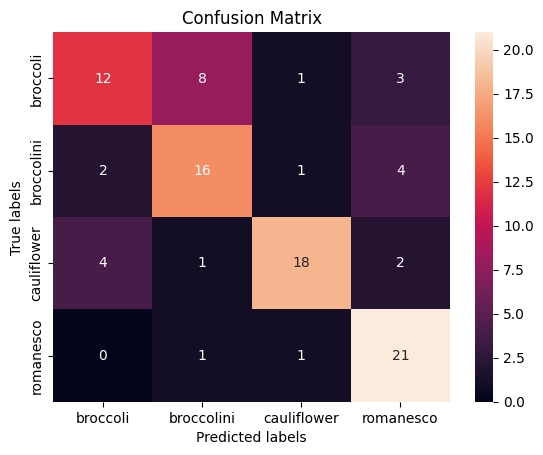

In [140]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(df['label_name'].unique())); ax.yaxis.set_ticklabels(list(df['label_name'].unique()));

In [92]:
list(df['label_name'].unique())

['broccoli', 'broccolini', 'cauliflower', 'romanesco']